<h3>Importing some stuff we will need</h3>

In [9]:
# Template for 1D model fitting with emcee
# Example: fitting a straight line in x and y with Gaussian priors
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pickle
plt.style.use('thomas')
import scipy.optimize as op
import corner

<h3>Creating data in x and y and obscuring it by uncertainties</h3>

In [3]:
# Create data
# True parameters
a = 5
b = 2

# Gaussian priors on a and b
mu_a = a
sigma_a = 2
mu_b = b
sigma_b = 2

# To have the same random output
seed = 1234
np.random.seed(seed=seed)

# Build data set with uncertainties
# Number of observations / data points
N_obs = 10
# x values
x     = np.linspace(0,10,N_obs)
# make "x error bars" as have distance between points (arbitrary here)
if len(x) > 1:
    x_err = (x[1] - x[0])/2.
# true y values according to model
y     = a + b*x
# y uncertainties (homoscedastic = all uncertainties equal)
y_err = np.repeat(5,N_obs)
# obscured data points (chosen as random around the true value according to the uncertainties)
yp = y + np.random.randn(N_obs)*y_err

# where to evaluate the model for posterior prediction
N_model = 100
x_model = np.linspace(-2.5,12.5,N_model)

<h3>Setting up "the model" to fit the data</h3>

In [15]:
# Define the posterior probability distribution function (PDF)
# Reminder: posteriorPDF(model parameters | data) = likelihood(data | model parameters) * priorPDF(model parameters)
# the emcee package uses logarithmic PDFs

# As prior, we assume normal distributions
def lnprior(theta):
    a, b = theta
    # the "priors" are part of the model we are trying to fit
    # maybe play around with these values to see what is going on
    mu_a = 5
    sigma_a = 2
    mu_b = 2
    sigma_b = 2
    # gaussian priors means adding a constraint to the fit according to the following functions
    # Prior(a) = 1/(np.sqrt(2*np.pi)*sigma_a)*np.exp(-0.5*((mu_a-a)/sigma_a)**2)
    # Prior(b) = 1/(np.sqrt(2*np.pi)*sigma_b)*np.exp(-0.5*((mu_b-b)/sigma_b)**2)
    # then taking the logarithm, ignoring the absolute normalisation
    return -0.5*(a-mu_a)**2/sigma_a**2 -0.5*(b-mu_b)**2/sigma_b**2

# As likelihood, we have to use the normal distribution, as we assumed our uncertainties to be normal
# This is equivalent to using chi2, but changes if we had a data generating process that counts things, for example
def lnlike(theta, x, y, yerr):
    a, b = theta
    model = a + b*x
    return -0.5*(np.sum( ((y-model)/yerr)**2 ))

# The total posterior is then merely the sum of both
# Here, I account for the fact that the log(prior) might not be finite (e.g. in other cases for a uniform distribution)
# and thus would return -infinity in the case of having a zero (or very very small) value
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

<h3>Finding the likelihood maximum (no priors included right now)</h3>

In [16]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [a, b], args=(x, yp, y_err))
a_ml, b_ml = result.x

<h3>Values at the maximum likelihood</h3>

In [17]:
print('[a,b] = ',a_ml,b_ml)

[a,b] =  7.172772143176748 1.421762073752186


<h3>Plotting the data, fitted maximum-likelihood model, and true model (from which the data were drawn)</h3>

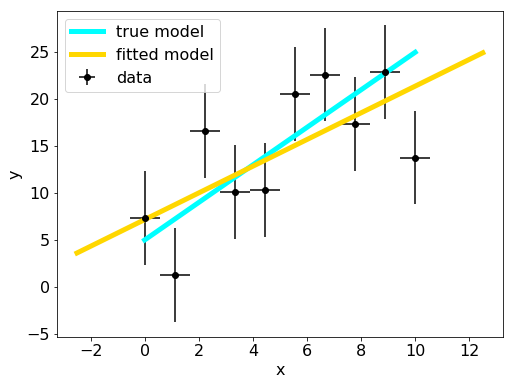

In [18]:
fig, ax = plt.subplots()

ax.errorbar(x,yp,yerr=y_err,xerr=x_err,fmt='ko',label='data')
ax.plot(x,y,color='cyan',linewidth=5,label='true model')
ax.plot(x_model,a_ml+x_model*b_ml,color='gold',linewidth=5,label='fitted model')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend()

<h3>Looking good? Or not? Why? Something wrong?<br>
    Let's get the posterior distributions for a and b, and draw the model according to all the information we can infer from the likelihood AND the priors:</h3>

<h3>Setting up a "Bayesian fit""</h3>

In [19]:
# we have 2 dimensions (a and b), and set up "walkers", i.e. points in the (a/b)-dimension to explore the posterior
# according to which parameters fits the data best (likelihood), and what additional information (prior) we have
ndim, nwalkers = 2, 10
pos = [result.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [20]:
# setting up a sampler which explore the function "lnprob" with nwalkers walkers, in two dimensions
# given the arguments (our data) x, yp, and yerr
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, yp, y_err))

In [21]:
# run the thing with 2000 iterations
# I like to see a progress bar because it tells me how long I'd have to wait if the model
# and data, etc., are more rigorous
from tqdm import tqdm_notebook as tqdm
_ = sampler.run_mcmc(pos, 2000,progress=True)

100%|██████████| 2000/2000 [00:01<00:00, 1747.37it/s]


In [22]:
# we have 2000 iterations and 10 walkers, so 20000 samples drawn
# we extract those by .flatchain'ing our samplers, and saving it to a variable (samples)
samples = sampler.flatchain
samples.shape

(20000, 2)

<h3>"corner" or "triangle" plot for how the posteriors for a and b look like:<br>
    Do we meet our expectations?</h3>

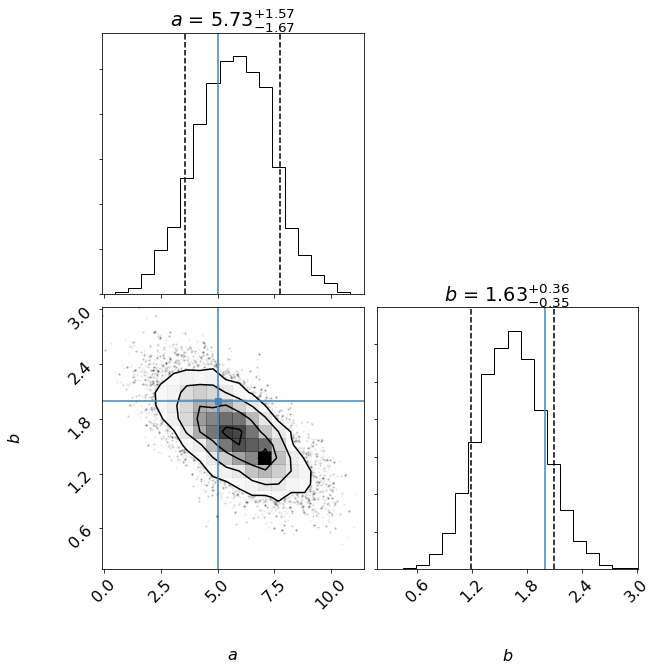

In [24]:
#let's plot the results
fig = corner.corner(samples, labels=['$a$', '$b$'],
                      truths=[a, b],quantiles=[0.1,0.9],show_titles=True)
fig.set_size_inches(10,10)

<h3>Plotting the model, according to all the information we extracted:</h3>

In [25]:
# evaluate models according to posterior sampling
# set up an array of y-values (same as x_models, i.e. N_model values), times the number of samples we had drawn:
y_models = np.zeros((N_model,samples.shape[0]))
# go through each pair of samples and calculate the line for all values of x_model
for i in range(samples.shape[0]):
    y_models[:,i] = samples[i,0] + x_model*samples[i,1]

In [27]:
# now we have a (100 times 20000) array, i.e. basically 20000 different straight lines
# these are constructed to the "allowed" values of our posteriors, i.e. are assigned a certain "probability",
# or better, are located inside a certain percentile, of the data space
y_models.shape

(100, 20000)

<h3>Plotting the model</h3>

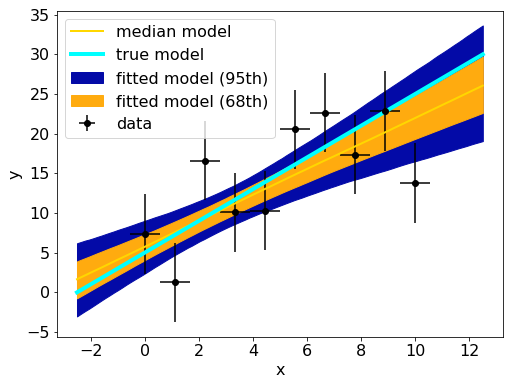

In [28]:
fig, ax = plt.subplots()

# data (as before)
ax.errorbar(x,yp,yerr=y_err,xerr=x_err,fmt='ko',label='data')

# now we check which points of all the 20000 lines we calculated are between
# a certain range
# first we calculate the 95.4% percentile (if assuming Gaussian, or according to "as if Gaussian", also "two sigma")
level = 95.4
ax.fill_between(x_model,
                np.percentile(y_models, 50 - 0.5*level, axis=1 ),
                np.percentile(y_models, 50 + 0.5*level, axis=1 ),
                color='xkcd:cobalt blue',alpha=1.0,label='fitted model (95th)')

# and 68.3% percentile ("1 sigma")
level = 68.3
ax.fill_between(x_model,
                np.percentile(y_models, 50 - 0.5*level, axis=1 ),
                np.percentile(y_models, 50 + 0.5*level, axis=1 ),
                color='xkcd:yellowish orange',alpha=1,label='fitted model (68th)')

# and the median model (basically the 0.00000...% percentile)
fit_model = np.median(y_models,axis=1)
ax.plot(x_model,fit_model,linewidth=2,color='gold',label='median model')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.plot(x_model,a+x_model*b,color='cyan',linewidth=4,label='true model')

ax.legend()

<h3>We see that the true model (cyan) is well inside the 1-sigma range (good).<br>
    We also see that the model fits the data somewhat well because our data points "hit" the 95% percentile of all the model (good)<br>
    You see that the "median model" is only one particular subset of models that fit the data (depending on what you actually want to do.<br>
    A quantification of "how good" the model actually fits will be done in an additional step, i.e. we will predict the outcome of "future experiments".</h3>